In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data_week_3.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
cols = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
df = df[cols].copy();
df.shape

(11914, 10)

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)

mean_price = df.msrp.mean()
df['above_average'] = (df.msrp >= mean_price).astype(int)
del df['msrp']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

In [9]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f'{c}: {auc:.3f}')

year: 0.688
engine_hp: 0.917
engine_cylinders: 0.766
highway_mpg: 0.633
city_mpg: 0.673


In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9790336815928319

In [11]:
def confusion_matrix_df(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positives = (y_val == 1)
        actual_negatives = (y_val == 0)
        
        pred_positives = (y_pred >= t)
        pred_negatives = (y_pred < t)
        
        tp = (actual_positives & pred_positives).sum()
        tn = (actual_negatives & pred_negatives).sum()
        
        fp = (actual_negatives & pred_positives).sum()
        fn = (actual_positives & pred_negatives).sum()
        
        scores.append((t, tp, tn, fp, fn))
    
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    return pd.DataFrame(scores, columns=columns)        

In [12]:
df_scores = confusion_matrix_df(y_val, y_pred)
df_scores[::10]

,threshold,tp,tn,fp,fn
0,0.0,654,0,1729,0
10,0.1,644,1395,334,10
20,0.2,623,1528,201,31
30,0.3,605,1585,144,49
40,0.4,590,1623,106,64
50,0.5,570,1656,73,84
60,0.6,550,1678,51,104
70,0.7,506,1699,30,148
80,0.8,464,1708,21,190
90,0.9,376,1726,3,278


In [13]:
df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
df_scores['recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
df_scores[::10]

,threshold,tp,tn,fp,fn,precision,recall
0,0.0,654,0,1729,0,0.274444,1.000000
10,0.1,644,1395,334,10,0.658487,0.984709
20,0.2,623,1528,201,31,0.756068,0.952599
30,0.3,605,1585,144,49,0.807744,0.925076
40,0.4,590,1623,106,64,0.847701,0.902141
50,0.5,570,1656,73,84,0.886470,0.871560
60,0.6,550,1678,51,104,0.915141,0.840979
70,0.7,506,1699,30,148,0.944030,0.773700
80,0.8,464,1708,21,190,0.956701,0.709480
90,0.9,376,1726,3,278,0.992084,0.574924


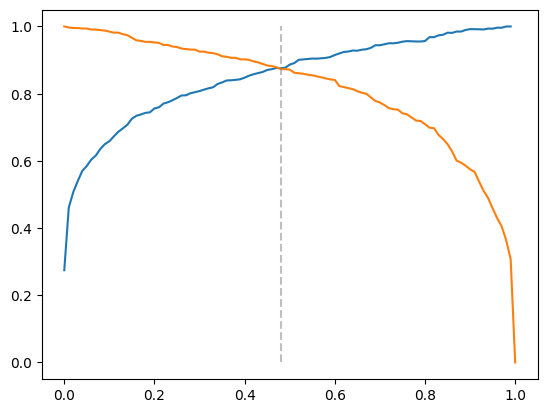

In [14]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)


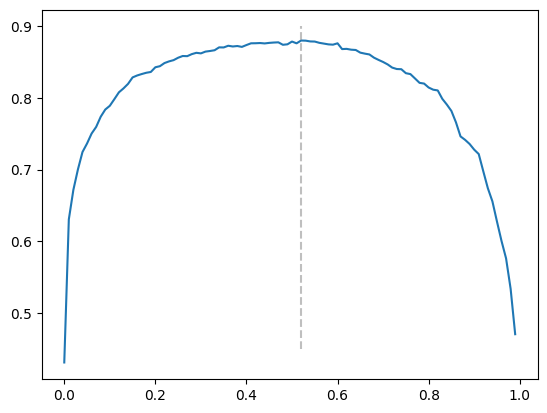

In [15]:
df_scores['f1'] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.52, 0.45, 0.9, color='grey', linestyle='--', alpha=0.5)

In [16]:
from sklearn.model_selection import KFold

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [18]:
columns = list(df.columns)
columns.remove('above_average')
columns

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [28]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [30]:
scores = []
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

print(f"KFold score: {np.mean(scores):.3f} +- {np.std(scores):.3f}")

0.979 +- 0.003


In [32]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
    print(f"KFold score: {np.mean(scores):.3f} +- {np.std(scores):.3f}")

KFold score: 0.952 +- 0.002
KFold score: 0.972 +- 0.002
KFold score: 0.978 +- 0.001
KFold score: 0.983 +- 0.003
